In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
folder = '/content/drive/My Drive/Colab Data/public_data'
image_size = (224, 224)
batch_size = 32

In [4]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=5,
        # width_shift_range=0.1,
        # height_shift_range=0.1,
        rescale=1./255,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
train_gen = datagen.flow_from_directory(
    folder + '/train',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=True  
)

test_gen = test_datagen.flow_from_directory(
    folder + '/test',
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=False 
)

Found 1605 images belonging to 13 classes.
Found 800 images belonging to 13 classes.


In [6]:
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions

model = VGG16(weights='imagenet')
model.summary()

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model.output
x = Flatten()(x)  # flatten from convolution tensor output  
x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(500, activation='relu')(x)
predictions = Dense(13, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

58892288/58889256 [==============================] - 0s 0us/step


In [8]:
epochs = 10

history = model.fit(
    train_gen, 
    epochs=epochs,
    verbose = 1,
    validation_data=test_gen
    )
model.save_weights('model_VGG16.h5') 

Epoch 1/10
51/51 [==============================] - 673s 13s/step - loss: 2.6884 - categorical_accuracy: 0.2673 - val_loss: 1.4787 - val_categorical_accuracy: 0.5450
Epoch 2/10
51/51 [==============================] - 22s 433ms/step - loss: 1.1020 - categorical_accuracy: 0.6249 - val_loss: 0.8362 - val_categorical_accuracy: 0.7050
Epoch 3/10
51/51 [==============================] - 22s 433ms/step - loss: 0.6995 - categorical_accuracy: 0.7601 - val_loss: 0.7872 - val_categorical_accuracy: 0.7237
Epoch 4/10
51/51 [==============================] - 22s 430ms/step - loss: 0.4342 - categorical_accuracy: 0.8579 - val_loss: 0.5480 - val_categorical_accuracy: 0.8163
Epoch 5/10
51/51 [==============================] - 22s 430ms/step - loss: 0.2611 - categorical_accuracy: 0.9159 - val_loss: 0.5692 - val_categorical_accuracy: 0.8037
Epoch 6/10
51/51 [==============================] - 22s 430ms/step - loss: 0.1994 - categorical_accuracy: 0.9346 - val_loss: 0.4509 - val_categorical_accuracy: 0.8537

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


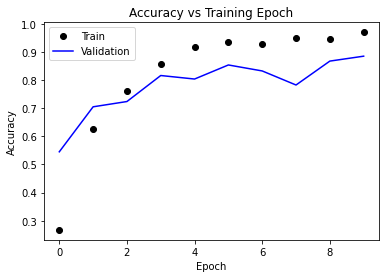

In [9]:
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd

plt.plot(history.history['categorical_accuracy'], 'ko')
plt.plot(history.history['val_categorical_accuracy'], 'b')

plt.title('Accuracy vs Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation']);

Instructions for updating:
Please use Model.predict, which supports generators.
0.885


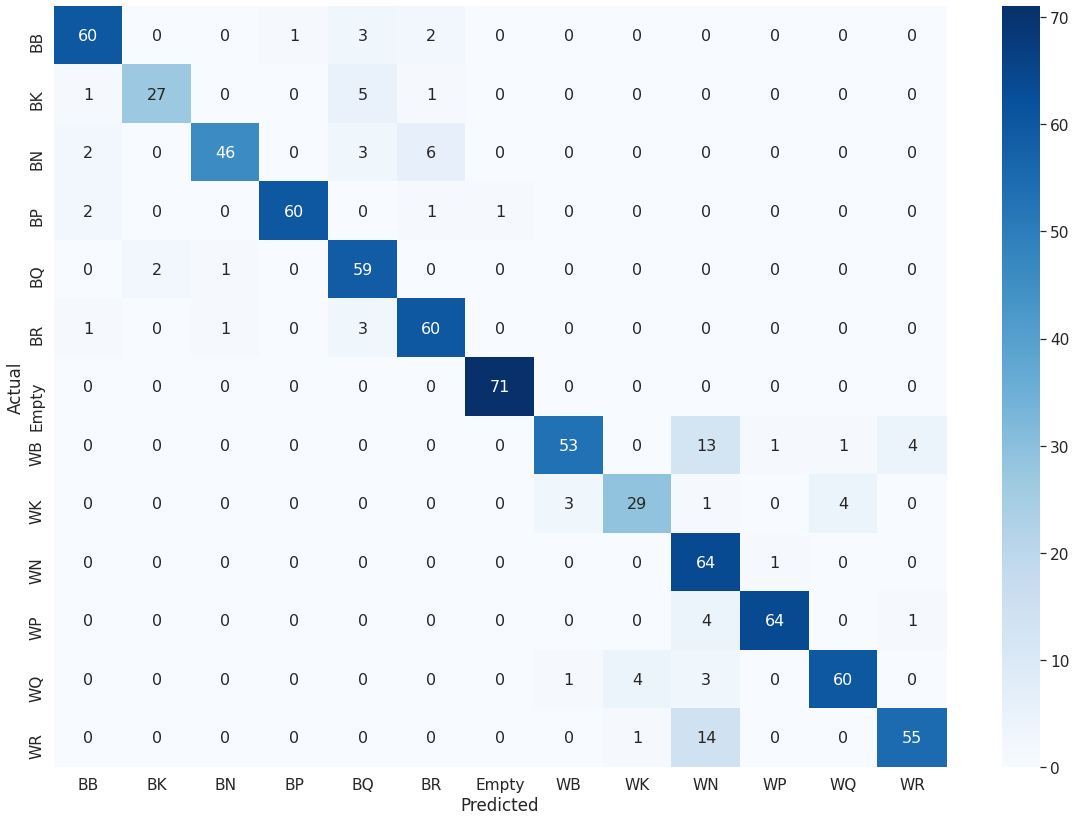

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['BB', 'BK', 'BN', 'BP', 'BQ', 'BR', 'Empty', 'WB', 'WK', 'WN', 'WP', 'WQ', 'WR']

test_gen.reset()
Y_pred = model.predict_generator(test_gen)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)
print(sum(y_pred==classes)/800)


data = confusion_matrix(classes, y_pred)
df_cm = pd.DataFrame(data, columns=target_names, index = target_names)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (20,14))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [11]:
print('Confusion Matrix')
print(data)
print('Classification Report')
print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))

Confusion Matrix
[[60  0  0  1  3  2  0  0  0  0  0  0  0]
 [ 1 27  0  0  5  1  0  0  0  0  0  0  0]
 [ 2  0 46  0  3  6  0  0  0  0  0  0  0]
 [ 2  0  0 60  0  1  1  0  0  0  0  0  0]
 [ 0  2  1  0 59  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  3 60  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 71  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 53  0 13  1  1  4]
 [ 0  0  0  0  0  0  0  3 29  1  0  4  0]
 [ 0  0  0  0  0  0  0  0  0 64  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  4 64  0  1]
 [ 0  0  0  0  0  0  0  1  4  3  0 60  0]
 [ 0  0  0  0  0  0  0  0  1 14  0  0 55]]
Classification Report
              precision    recall  f1-score   support

          BB       0.91      0.91      0.91        66
          BK       0.93      0.79      0.86        34
          BN       0.96      0.81      0.88        57
          BP       0.98      0.94      0.96        64
          BQ       0.81      0.95      0.87        62
          BR       0.86      0.92      0.89        65
       Empty       0.99      1.00  

In [12]:
from keras.applications.vgg19 import VGG19
from keras.applications.imagenet_utils import decode_predictions

model_two = VGG19(weights='imagenet')
model_two.summary()

574717952/574710816 [==============================] - 3s 0us/step
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from keras.models import Model

base_model_two = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
 
# Freeze convolutional layers
for layer in base_model_two.layers:
    layer.trainable = False    

# Establish new fully connected block
x = base_model_two.output
x = Flatten()(x)  # flatten from convolution tensor output  
x = Dense(500, activation='relu')(x) # number of layers and units are hyperparameters, as usual
x = Dense(500, activation='relu')(x)
predictions = Dense(13, activation='softmax')(x) # should match # of classes predicted

# this is the model we will train
model_two = Model(inputs=base_model_two.input, outputs=predictions)
model_two.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

80142336/80134624 [==============================] - 0s 0us/step


In [14]:
epochs = 10

history = model_two.fit(
    train_gen, 
    epochs=epochs,
    verbose = 1,
    validation_data=test_gen
    )
model.save_weights('model_VGG19.h5') 

Epoch 1/10
51/51 [==============================] - 23s 454ms/step - loss: 2.7242 - accuracy: 0.2380 - val_loss: 1.8447 - val_accuracy: 0.3500
Epoch 2/10
51/51 [==============================] - 23s 451ms/step - loss: 1.3450 - accuracy: 0.5464 - val_loss: 1.0877 - val_accuracy: 0.6275
Epoch 3/10
51/51 [==============================] - 23s 447ms/step - loss: 0.8556 - accuracy: 0.7065 - val_loss: 0.8117 - val_accuracy: 0.7138
Epoch 4/10
51/51 [==============================] - 23s 450ms/step - loss: 0.7130 - accuracy: 0.7514 - val_loss: 0.8722 - val_accuracy: 0.6737
Epoch 5/10
51/51 [==============================] - 23s 452ms/step - loss: 0.5393 - accuracy: 0.8150 - val_loss: 0.6614 - val_accuracy: 0.7600
Epoch 6/10
51/51 [==============================] - 23s 455ms/step - loss: 0.4539 - accuracy: 0.8442 - val_loss: 0.7770 - val_accuracy: 0.7375
Epoch 7/10
51/51 [==============================] - 23s 447ms/step - loss: 0.3024 - accuracy: 0.8978 - val_loss: 0.6327 - val_accuracy: 0.7875

In [15]:
test_gen.reset()
Y_pred = model_two.predict_generator(test_gen)
classes = test_gen.classes[test_gen.index_array]
y_pred = np.argmax(Y_pred, axis= -1)
print(sum(y_pred==classes)/800)


print('Confusion Matrix')
print(confusion_matrix(classes, y_pred))
print('Classification Report')
print(classification_report(test_gen.classes[test_gen.index_array], y_pred, target_names=target_names))

0.7725
Confusion Matrix
[[46  0  6  8  6  0  0  0  0  0  0  0  0]
 [ 0 21  0  0 11  1  0  0  1  0  0  0  0]
 [ 2  0 51  1  1  1  0  0  0  1  0  0  0]
 [ 0  0  1 58  1  0  1  0  0  0  3  0  0]
 [ 0  2  0  0 59  0  0  0  0  1  0  0  0]
 [ 5  0 33  2  9 14  1  0  0  0  0  0  1]
 [ 0  0  0  0  0  0 68  0  0  1  2  0  0]
 [ 0  0  0  0  0  0  0 41  1 19  9  0  2]
 [ 0  0  0  0  0  0  0  2 26  1  0  8  0]
 [ 0  0  0  0  0  0  0  0  1 58  4  1  1]
 [ 0  0  0  0  0  0  0  1  0  3 65  0  0]
 [ 0  0  0  0  0  0  0  2  6  4  0 56  0]
 [ 0  0  0  0  0  0  0  0  1 12  1  1 55]]
Classification Report
              precision    recall  f1-score   support

          BB       0.87      0.70      0.77        66
          BK       0.91      0.62      0.74        34
          BN       0.56      0.89      0.69        57
          BP       0.84      0.91      0.87        64
          BQ       0.68      0.95      0.79        62
          BR       0.88      0.22      0.35        65
       Empty       0.97     